In [2]:
import os
import keras
import random
import numpy as np
import sys
import operator
import math
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img

import matplotlib.pyplot as plt
import itertools
from skimage import transform
from skimage.io import imread, imsave, imshow
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time

current_milli_time = lambda: int(round(time.time() * 1000))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Helper Functions

In [3]:
"""
    Preprocess image, normalizing and resizing it

    :param frame: RGBA frame
"""    
def preprocess_image(frame):
    
    # Normalize Pixel Values
    normalized_frame = frame/255.0 - 0.5
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, IMAGE_PP_SIZE)
    
    # Create a 3-Channel image
#     final_image = np.dstack((preprocessed_frame, preprocessed_frame, preprocessed_frame))
    
    return preprocessed_frame

"""
    Create 2D label list from 1D list
    
    :param labels: 1D label list
"""

def make_labels(labels):
    np_labels = np.zeros((len(labels), CLASS_NUMBER))
    
    for i in range(len(labels)):
        np_labels[i, labels[i]] = 1
    
    return np_labels

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def choices(l, k=1):
    new_list = []
    for i in range(k):
        new_list.append(random.choice(l))
    return new_list

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)
    
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Define Globals

In [4]:
IMAGE_PP_SIZE = [150, 150]
EPOCHS = 100
BATCH_SIZE = 100
TRAIN_STEP = 1591
VAL_SIZE = 100
CLASS_NUMBER = 7

RELOAD_MODEL = False

DATA_FOLDER_ROOT = "/media/matheusmortatti/External/dom-roque"
DATA_FOLDER = "/media/matheusmortatti/External/dom-roque/original"
DATA_FOLDER_PROCESSED = "/media/matheusmortatti/External/dom-roque/preprocessed"

# Train, Val, Test
DATA_RATIO = [0.7, 0.2, 0.1]

## DATA PREPROCESSING

This cell will take all the images and preprocess it, saving the results onto another folder

In [13]:
#
# If the folder doesn't exists yet, create it and preprocess all images
#

if not os.path.isdir(DATA_FOLDER_ROOT + '/preprocessed'):
    os.mkdir(DATA_FOLDER_ROOT + '/preprocessed')
    
    labels = os.listdir(DATA_FOLDER)
    for label in labels:
        folder_path = DATA_FOLDER + '/' + label
        if not os.path.isdir(folder_path):
            continue
        os.mkdir(DATA_FOLDER_PROCESSED + '/' + label)

    for label in labels:
        folder_path = DATA_FOLDER + '/' + label
        if not os.path.isdir(folder_path):
            continue

        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.split('.')[-1] != "jpg":
                    continue
                img_path = os.path.join(root, file)
                img = imread(img_path)
                x = preprocess_image(img)
#                 x = array_to_img(x)
#                 save_img(DATA_FOLDER_PROCESSED + '/' + label + '/' + file, x)
                imsave(DATA_FOLDER_PROCESSED + '/' + label + '/' + file, x)

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /media/matheusmortatti/External/dom-roque/preprocessed/balancete/DALLEMOLE.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/matheusmortatti/.loc

## DATA AUGMENTATION

Running this cell will take your data folder and augment all the files within it.

DO NOT RUN THIS CELL TWICE

In [5]:
#
# Create more data
#

folder = DATA_FOLDER

datagen = ImageDataGenerator(rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0,
                             zoom_range=0.01)

labels = os.listdir(folder)
label_count = {}

for label in labels:
    folder_path = folder + '/' + label
    if not os.path.isdir(folder_path):
        continue

    for root, dirs, files in os.walk(folder_path):
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += len(files)

label_max = max(zip(label_count.values(), label_count.keys()))[0]
print(label_max)
print()

for label in labels:
    folder_path = folder + '/' + label
    if not os.path.isdir(folder_path):
        continue
    
    
    if not os.path.isdir(folder_path + '/augmented'):
        os.mkdir(folder_path + '/augmented')
    else:
        continue
        
    amount = math.ceil(label_max / label_count[label]) - 1
    print(label_count[label])
    print(amount)
    print()

    for root, dirs, files in os.walk(folder_path):
        
        if 'augmented' in root:
            continue
            
        print(root)
        
        for file in files:
            if file.split('.')[-1] != "jpg":
                continue
            img_path = os.path.join(root, file)
            img = load_img(img_path)
            x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

            i = 0
            for batch in datagen.flow(x, 
                                      batch_size=1,
                                      save_to_dir=folder_path + '/augmented', 
                                      save_prefix='_' + str(current_milli_time()), 
                                      save_format='jpg'):
                i += 1
                if i >= amount:
                    break  # otherwise the generator would loop indefinitely

1654

7
236

/media/matheusmortatti/External/dom-roque/original/nf
/media/matheusmortatti/External/dom-roque/original/nf/NF-E
/media/matheusmortatti/External/dom-roque/original/nf/NFS


## Create Labels File

In [6]:
folder = DATA_FOLDER

def choices(l, k):
    c = []
    for i in range(k):
        el = random.choice(l)
        c.append(el)
        l.remove(el)
    return c, l

labels = os.listdir(folder)

i = 0
train = []
test = []
val = []
for label in labels:
    if not os.path.isdir(folder + '/' + label):
        continue

    for root, dirs, files in os.walk(folder + '/' + label):
        f = []
        for file in files:
            if ('jpg' not in file) and ('jpeg' not in file):
                continue
            f.append(file)
            
        n = len(f)
        n_train = int(DATA_RATIO[0] * n)
        n_val = int(DATA_RATIO[1] * n)
        n_test = int(DATA_RATIO[2] * n)

        lt, f = choices(f, n_train)
        for l in lt:
            train.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        lt, f = choices(f, n_val)
        for l in lt:
            l = l.replace(' ', '\ ')
            val.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        lt, f = choices(f, n_test)
        for l in lt:
            l = l.replace(' ', '\ ')
            test.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        

    i += 1

random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

with open(folder + '/' + 'labels_train.txt', 'a') as f:
    for l in train:
        f.write(l)

with open(folder + '/' + 'labels_val.txt', 'a') as f:
    for l in val:
        f.write(l)

with open(folder + '/' + 'labels_test.txt', 'a') as f:
    for l in test:
        f.write(l)

balancete 173
balancete 1211
balanco 281
balanco 1123
contas 55
contas 1319
dre 37
dre 20
dre 1367
LA 209
LA 0
LA 60
LA 60
LA 60
LA 55
LA 0
LA 60
LA 60
LA 60
LA 55
LA 0
LA 24
LA 24
LA 24
LA 22
LA 0
LA 55
LA 60
LA 60
LA 55
LA 60
LA 60
LA 60
LA 60
LA 60
LA 35
LA 35
LA 281
LB 79
LB 24
LB 0
LB 24
LB 24
LB 24
LB 22
LB 24
LB 24
LB 22
LB 24
LB 14
LB 24
LB 24
LB 1268
nf 7
nf 1628
nf 0
nf 0


## Load Model or Create it

In [5]:
if RELOAD_MODEL:
    try:
        json_file = open('model_imgnet_domroque.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("model_imgnet_domroque.h5")
    except:
        conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
        conv_base.traiable = False
        model = Sequential()
        model.add(conv_base)
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(CLASS_NUMBER, activation='softmax'))
else:
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(CLASS_NUMBER, activation='softmax'))
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [6]:

#
# Define train, validation and test lists
#

folder = DATA_FOLDER

train_labels = []
val_labels = []
test_labels = []

train_input = []
val_input = []
test_input = []

#
# Load validation dataset
#

labels_file = open(folder + "/labels_val.txt")


for line in labels_file:
    sp = line.split()
    
    img = imread(sp[0])
    img = preprocess_image(img)
    
    val_input.append(img)
    val_labels.append(int(sp[1]))

x_val = np.asarray(val_input)
y_val = make_labels(val_labels)
    
labels_file.close()

#
# Load training dataset
#
    
labels_file = open(folder + "/labels_train.txt")
    
for line in labels_file:
    sp = line.split()
    
    img = imread(sp[0])
    img = preprocess_image(img)
    
    train_input.append(img)
    train_labels.append(int(sp[1]))

x_train = np.asarray(train_input)
y_train = make_labels(train_labels)
    
labels_file.close()

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/matheusmortatti/.local/lib/python3.5/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


## PCA Analisys

(7325, 150, 150, 3)


Text(0,0.5,'Cumulative explained variance')

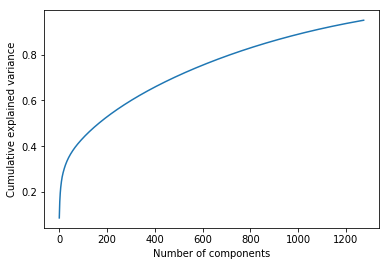

In [7]:
print(x_train.shape)
X_train = StandardScaler().fit_transform(x_train[:2000].reshape(2000, 150*150*3))
pca = PCA(0.95)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [15]:
xp_train = pca.transform(x_train[:2000].reshape(2000, 150*150*3))

## Train!

In [16]:
tbCallback = keras.callbacks.TensorBoard(log_dir='./logs/imgnet_domroque', histogram_freq=0,  
          write_graph=True, write_images=True)

model.fit(xp_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks=[tbCallback])

ValueError: Error when checking input: expected vgg16_input to have 4 dimensions, but got array with shape (2000, 1276)

In [11]:
#
# SAVE MODEL STRUCTURE AND WEIGHTS
#

model_json = model.to_json()
with open("model_imgnet_domroque.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_imgnet_domroque.h5")

keras.callbacks.TensorBoard('./logs/imgnet_domroque')

In [ ]:
#
# RELOAD VALIDATION DATA IF NECESSARY
#

val_input = []
val_labels = []

labels_file = open(DATA_FOLDER + "/labels_val.txt")

for line in labels_file:
    sp = line.split()
    
    val_input.append(preprocess_image(imread(DATA_FOLDER + sp[0][1:])))
    val_labels.append(int(sp[1]))

x_val = np.asarray(val_input)
y_true = np.asarray(val_labels)
    
labels_file.close()

## Predict Validation Results

In [12]:
y_pred = model.predict_classes(x_val)

## Plot Confusion Matrix and Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       276
           1       0.99      0.98      0.99       280
           2       1.00      1.00      1.00       274
           3       0.98      1.00      0.99       284
           4       1.00      0.96      0.98       327
           5       0.96      1.00      0.98       314
           6       1.00      1.00      1.00       326

   micro avg       0.99      0.99      0.99      2081
   macro avg       0.99      0.99      0.99      2081
weighted avg       0.99      0.99      0.99      2081



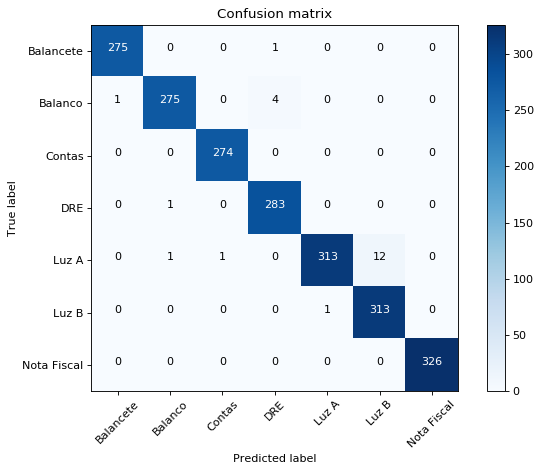

In [13]:
labels_text = ["Balancete", "Balanco", "Contas", "DRE", "Luz A", "Luz B", "Nota Fiscal"]
y_true = np.asarray(val_labels)

plot_confusion_matrix(confusion_matrix(y_true, y_pred), labels_text)
print(classification_report(y_true, y_pred))